<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>



**Mastering Data-Driven Finance**
# Exploring Simple Moving Averages

## Introduction

This Jupyter Notebook explores the concept of Simple Moving Averages (SMAs) and their application in financial analysis. SMAs are widely used in the field of technical analysis to smooth out price data and identify trends over a specified period. In this notebook, we'll implement SMAs using Python and visualize their impact on historical price data.

## Objectives

- Understand the basics of Simple Moving Averages.
- Implement SMAs using the Pandas library in Python.
- Analyze how SMAs can be used to identify trends and potential trading signals.
- Visualize the results to gain insights into price movements.



### Data Import

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt

In [2]:
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%config InlineBackend.figure_format = 'svg'

/tmp/ipykernel_42/3039082668.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
raw = pd.read_csv('http://hilpisch.com/tr_eikon_eod_data.csv',
                  index_col=0, parse_dates=True)

In [4]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2216 entries, 2010-01-01 to 2018-06-29
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2138 non-null   float64
 1   MSFT.O  2138 non-null   float64
 2   INTC.O  2138 non-null   float64
 3   AMZN.O  2138 non-null   float64
 4   GS.N    2138 non-null   float64
 5   SPY     2138 non-null   float64
 6   .SPX    2138 non-null   float64
 7   .VIX    2138 non-null   float64
 8   EUR=    2216 non-null   float64
 9   XAU=    2211 non-null   float64
 10  GDX     2138 non-null   float64
 11  GLD     2138 non-null   float64
dtypes: float64(12)
memory usage: 225.1 KB


In [5]:
symbol = 'AAPL.O'

In [6]:
data = (
    pd.DataFrame(raw[symbol])
    .dropna()
)

### Trading Strategy

In [7]:
SMA1 = 42  
SMA2 = 252  

In [8]:
data['SMA1'] = data[symbol].rolling(SMA1).mean()  
data['SMA2'] = data[symbol].rolling(SMA2).mean()  

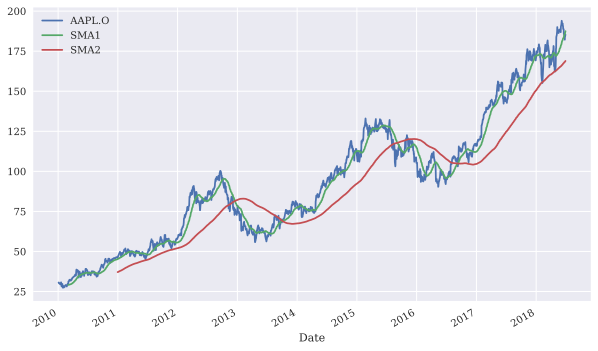

In [9]:
data.plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_plot_01.png')

In [10]:
data.dropna(inplace=True)

In [11]:
data['Position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)  

In [12]:
data.tail()

,AAPL.O,SMA1,SMA2,Position
Date,,,,
2018-06-25,182.17,185.606190,168.265556,1
2018-06-26,184.43,186.087381,168.418770,1
2018-06-27,184.16,186.607381,168.579206,1
2018-06-28,185.50,187.089286,168.736627,1
2018-06-29,185.11,187.470476,168.901032,1


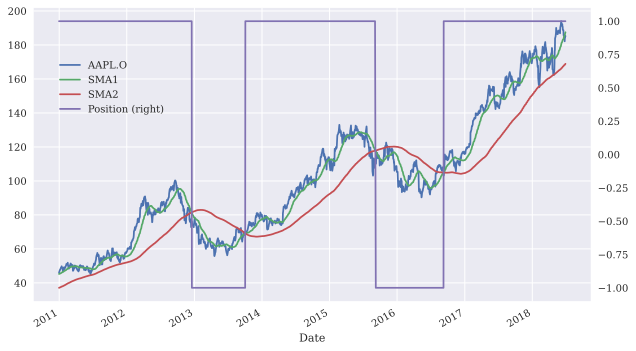

In [13]:
ax = data.plot(secondary_y='Position', figsize=(10, 6))
ax.get_legend().set_bbox_to_anchor((0.25, 0.85));
# plt.savefig('../../images/ch15/strat_plot_02.png')

### Vectorized Backtesting

In [14]:
data['Returns'] = np.log(data[symbol] / data[symbol].shift(1))  

In [15]:
data['Strategy'] = data['Position'].shift(1) * data['Returns']  

In [16]:
data.round(4).head()

,AAPL.O,SMA1,SMA2,Position,Returns,Strategy
Date,,,,,,
2010-12-31,46.0800,45.2810,37.1207,1,NaN,NaN
2011-01-03,47.0814,45.3497,37.1862,1,0.0215,0.0215
2011-01-04,47.3271,45.4126,37.2525,1,0.0052,0.0052
2011-01-05,47.7142,45.4661,37.3223,1,0.0081,0.0081
2011-01-06,47.6757,45.5226,37.3921,1,-0.0008,-0.0008


In [17]:
data.dropna(inplace=True)

In [18]:
np.exp(data[['Returns', 'Strategy']].sum())  

Returns     4.017148
Strategy    5.811299
dtype: float64

In [19]:
data[['Returns', 'Strategy']].std() * 252 ** 0.5  

Returns     0.250571
Strategy    0.250407
dtype: float64

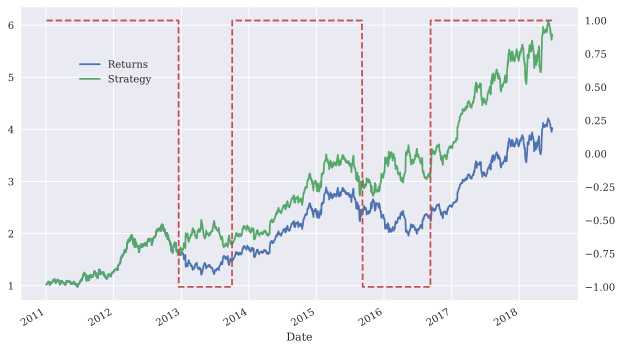

In [20]:
ax = data[['Returns', 'Strategy']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6))
data['Position'].plot(ax=ax, secondary_y='Position', style='--')
ax.get_legend().set_bbox_to_anchor((0.25, 0.85));
# plt.savefig('../../images/ch15/strat_plot_03.png');

### Optimization

In [21]:
from itertools import product

In [22]:
sma1 = range(20, 61, 4)  
sma2 = range(180, 281, 10)  

In [23]:
results = pd.DataFrame()
for SMA1, SMA2 in product(sma1, sma2):  
    data = pd.DataFrame(raw[symbol])
    data.dropna(inplace=True)
    data['Returns'] = np.log(data[symbol] / data[symbol].shift(1))
    data['SMA1'] = data[symbol].rolling(SMA1).mean()
    data['SMA2'] = data[symbol].rolling(SMA2).mean()
    data.dropna(inplace=True)
    data['Position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
    data['Strategy'] = data['Position'].shift(1) * data['Returns']
    data.dropna(inplace=True)
    perf = np.exp(data[['Returns', 'Strategy']].sum())
    results = pd.concat([results, pd.DataFrame(
        {'SMA1': SMA1, 'SMA2': SMA2,
         'MARKET': perf['Returns'],
         'STRATEGY': perf['Strategy'],
         'OUT': perf['Strategy'] - perf['Returns']},
         index=[0])], ignore_index=True)

# Reset the index of the final results DataFrame
results.reset_index(drop=True, inplace=True)
# for SMA1, SMA2 in product(sma1, sma2):  
#     data = pd.DataFrame(raw[symbol])
#     data.dropna(inplace=True)
#     data['Returns'] = np.log(data[symbol] / data[symbol].shift(1))
#     data['SMA1'] = data[symbol].rolling(SMA1).mean()
#     data['SMA2'] = data[symbol].rolling(SMA2).mean()
#     data.dropna(inplace=True)
#     data['Position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
#     data['Strategy'] = data['Position'].shift(1) * data['Returns']
#     data.dropna(inplace=True)
#     perf = np.exp(data[['Returns', 'Strategy']].sum())
    
#     results = result.append(pd.DataFrame(
#                 {'SMA1': SMA1, 'SMA2': SMA2,
#                  'MARKET': perf['Returns'],
#                  'STRATEGY': perf['Strategy'],
#                  'OUT': perf['Strategy'] - perf['Returns']},
#                  index=[0]), ignore_index=True)  
    



In [24]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SMA1      121 non-null    int64  
 1   SMA2      121 non-null    int64  
 2   MARKET    121 non-null    float64
 3   STRATEGY  121 non-null    float64
 4   OUT       121 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 4.9 KB


In [25]:
results.sort_values('OUT', ascending=False).head(7)

,SMA1,SMA2,MARKET,STRATEGY,OUT
56,40,190,4.650342,7.175173,2.524831
39,32,240,4.045619,6.558690,2.513071
59,40,220,4.220272,6.544266,2.323994
46,36,200,4.074753,6.389627,2.314874
55,40,180,4.574979,6.857989,2.283010
70,44,220,4.220272,6.469843,2.249571
101,56,200,4.074753,6.319524,2.244772


## Random Walk Hypothesis

In [26]:
symbol = '.SPX'

In [27]:
data = pd.DataFrame(raw[symbol])

In [28]:
lags = 5
cols = []
for lag in range(1, lags + 1):
    col = 'lag_{}'.format(lag)  
    data[col] = data[symbol].shift(lag)  
    cols.append(col)  

In [29]:
data.head(7)

,.SPX,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,1132.99,NaN,NaN,NaN,NaN,NaN
2010-01-05,1136.52,1132.99,NaN,NaN,NaN,NaN
2010-01-06,1137.14,1136.52,1132.99,NaN,NaN,NaN
2010-01-07,1141.69,1137.14,1136.52,1132.99,NaN,NaN
2010-01-08,1144.98,1141.69,1137.14,1136.52,1132.99,NaN
2010-01-11,1146.98,1144.98,1141.69,1137.14,1136.52,1132.99


In [30]:
data.dropna(inplace=True)

In [31]:
reg = np.linalg.lstsq(data[cols], data[symbol], rcond=-1)[0]

In [32]:
reg.round(3)

array([0.966, 0.005, 0.025, 0.   , 0.003])

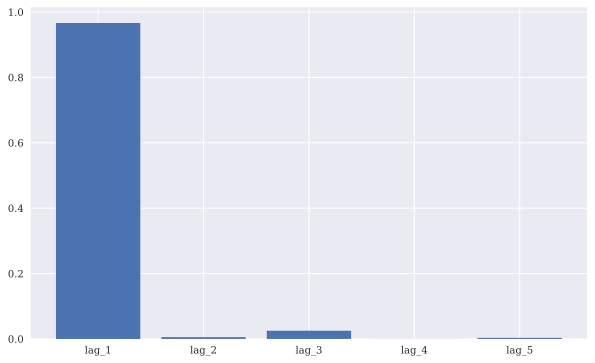

In [33]:
plt.figure(figsize=(10, 6))
plt.bar(cols, reg);
# plt.savefig('../../images/ch15/strat_plot_04.png');

In [34]:
data['Prediction'] = np.dot(data[cols], reg)

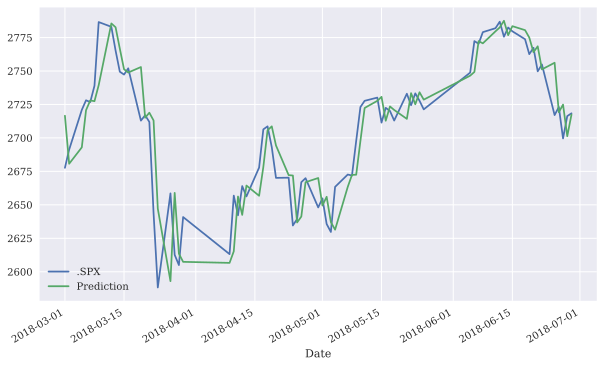

In [35]:
data[[symbol, 'Prediction']].iloc[-75:].plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_plot_05.png');